# 📈 Time Series Forecasting of Wikipedia Pageviews for Figma (software)|Prophet

This notebook explores daily pageviews for the [Figma Wikipedia article](https://en.wikipedia.org/wiki/Figma_(software)) from January 2022 onwards.  
The objective is to build a time series model that forecasts daily pageviews until mid-2026.  
This task was developed as part of a Data Science Internship technical challenge at SearchPilot, for Prophet Forecast for Figma Pageviews

## 📚 Table of Contents
1. [Introduction](#Introduction)
2. [Importing Libraries](#Importing-libraries)
3. [Data Loading](#data-loading)
5. [Feature Engineering](#Feature-Engineering)
6. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
7. [Train Test Split](#Train-Test-Split)
8. [Fit Prophet](#Fit-Prophet)
9. [Forecasting with Prophet](#forecasting-with-prophet)

In [9]:
!pip install prophet

In [76]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series forecasting
from prophet import Prophet

# Date handling
from datetime import datetime

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import requests
from datetime import datetime

%matplotlib inline
# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [78]:
def fetch_pageviews(article='Figma_(software)', start_date='2022-01-01', end_date=None,
                    granularity='daily', platform='all-access', agent='user', project='en.wikipedia'):
    """
    Fetches pageviews for a Wikipedia article using the Wikimedia REST API.
    """

    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    # Convert dates to API format
    start_fmt = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y%m%d')
    end_fmt = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y%m%d')

    # Build API URL
    url = (
        f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/'
        f'{project}/{platform}/{agent}/{article}/{granularity}/{start_fmt}/{end_fmt}'
    )

    headers = {
        'User-Agent': 'SamiraDSInternProject/1.0 (world.skc@gmail.com)'
    }

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")

    data = response.json()

    records = []
    for item in data['items']:
        full_date = datetime.strptime(str(item['timestamp']), '%Y%m%d%H')
        date = full_date if granularity == 'daily' else datetime(full_date.year, full_date.month, 1)
        views = item['views']
        records.append({'date': date, 'views': views})

    return pd.DataFrame(records)


In [17]:
# Daily, all-access, user traffic
df_daily = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')


In [19]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1250 non-null   datetime64[ns]
 1   views   1250 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


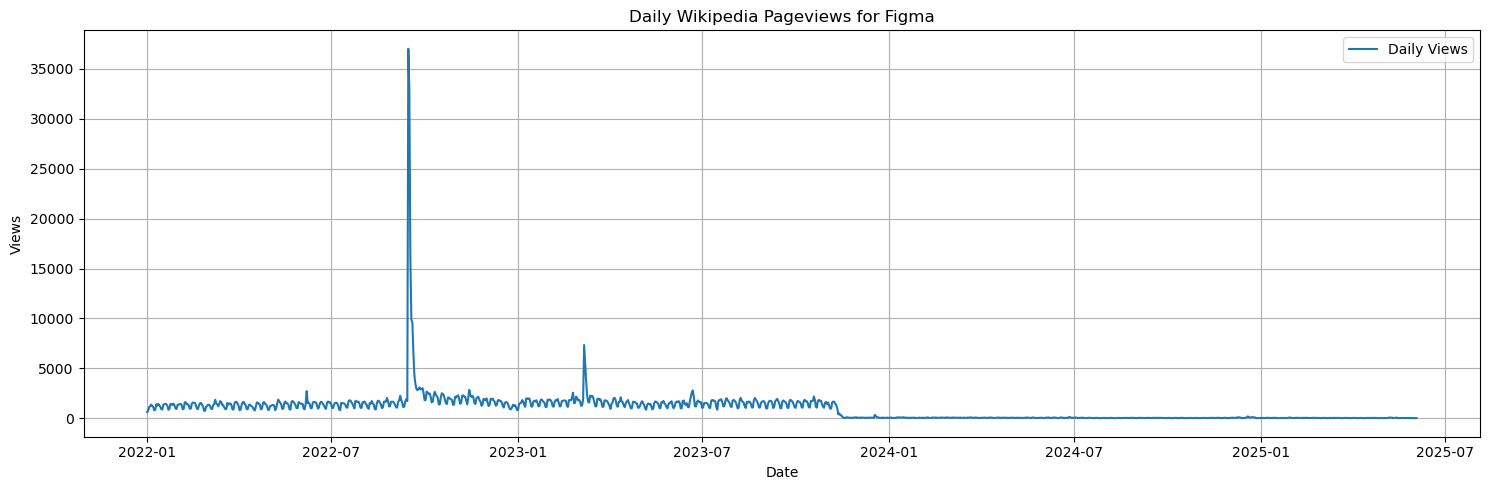

In [23]:
df_daily = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')
df_daily['date'] = pd.to_datetime(df_daily['date'])

plt.figure(figsize=(15, 5))
plt.plot(df_daily['date'], df_daily['views'], label='Daily Views')
plt.title("Daily Wikipedia Pageviews for Figma")
plt.xlabel("Date")
plt.ylabel("Views")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Feature Engineering
df_daily['day_of_week'] = df_daily.index.dayofweek
df_daily['is_weekend'] = df_daily['day_of_week'].isin([5, 6]).astype(int)
df_daily['month'] = df_daily.index.month
df_daily['rolling_mean_7'] = df_daily['views'].rolling(window=7).mean()
df_daily['rolling_std_7'] = df_daily['views'].rolling(window=7).std()

In [41]:
# Prophet needs 'ds' and 'y' only; other features are not directly used unless holidays are defined
df_prophet = df_daily[['views']].reset_index().rename(columns={'date': 'ds', 'views': 'y'})


                      date         views
count                 1250   1250.000000
mean   2023-09-17 12:00:00    948.308000
min    2022-01-01 00:00:00     13.000000
25%    2022-11-09 06:00:00     51.250000
50%    2023-09-17 12:00:00    985.000000
75%    2024-07-25 18:00:00   1563.750000
max    2025-06-03 00:00:00  36996.000000
std                    NaN   1697.810192
date     0
views    0
dtype: int64


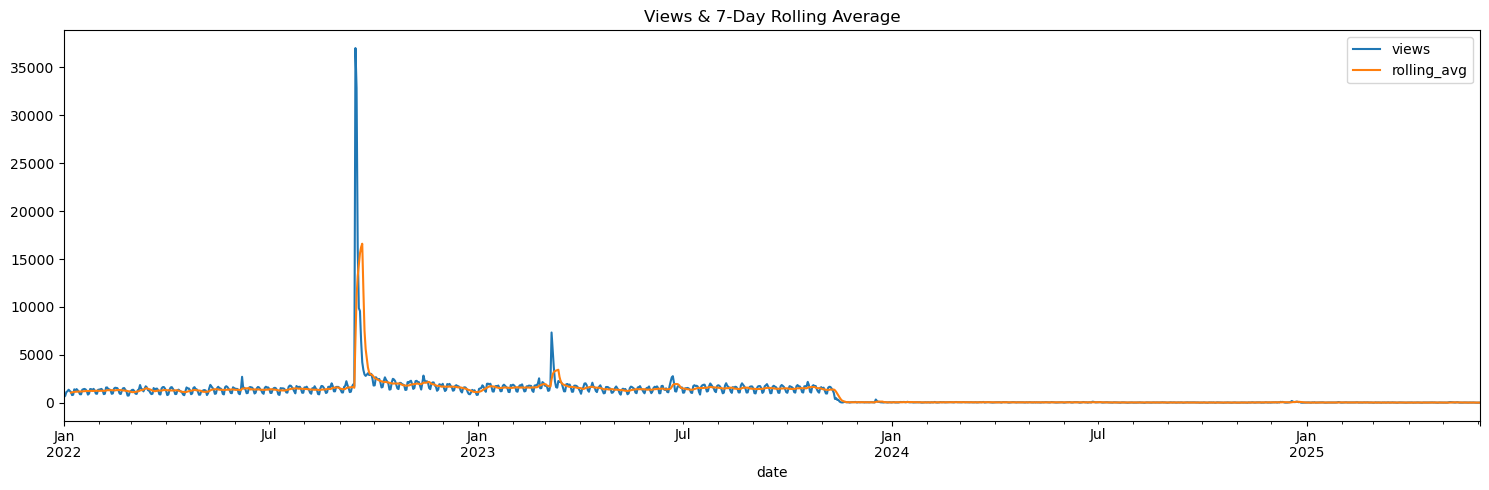

In [32]:
# Summary statistics
print(df_daily.describe())

# Check for missing data
print(df_daily.isnull().sum())

# Rolling average
df_daily.set_index('date', inplace=True)
df_daily['rolling_avg'] = df_daily['views'].rolling(window=7).mean()

df_daily[['views', 'rolling_avg']].plot(figsize=(15, 5), title="Views & 7-Day Rolling Average")
plt.tight_layout()
plt.show()


In [34]:
# Preprocessing
df_prophet = df_daily.reset_index()[['date', 'views']].rename(columns={'date': 'ds', 'views': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


In [47]:
desc_stats = df_daily.describe()
df_daily.describe()

,views,rolling_avg,day_of_week,is_weekend,month,rolling_mean_7,rolling_std_7
count,1250.000000,1244.000000,1250.0000,1250.00000,1250.000000,1244.000000,1244.000000
mean,948.308000,950.546509,3.0000,0.28640,6.096800,950.546509,286.251831
std,1697.810192,1304.995642,2.0028,0.45226,3.462863,1304.995642,1143.576972
min,13.000000,32.142857,0.0000,0.00000,1.000000,32.142857,2.267787
25%,51.250000,54.250000,1.0000,0.00000,3.000000,54.250000,12.391433
50%,985.000000,1237.857143,3.0000,0.00000,6.000000,1237.857143,232.934999
75%,1563.750000,1500.035714,5.0000,1.00000,9.000000,1500.035714,309.470637
max,36996.000000,16599.000000,6.0000,1.00000,12.000000,16599.000000,16337.116596


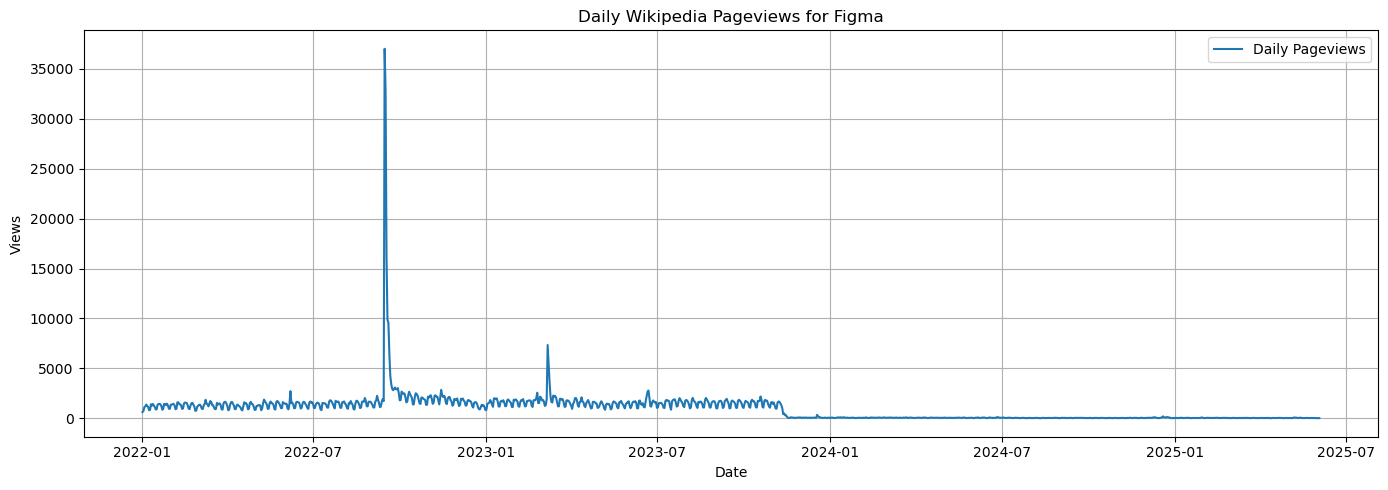

In [51]:
# Time-series plot
plt.figure(figsize=(14, 5))
plt.plot(df_daily.index, df_daily['views'], label='Daily Pageviews')
plt.title('Daily Wikipedia Pageviews for Figma')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

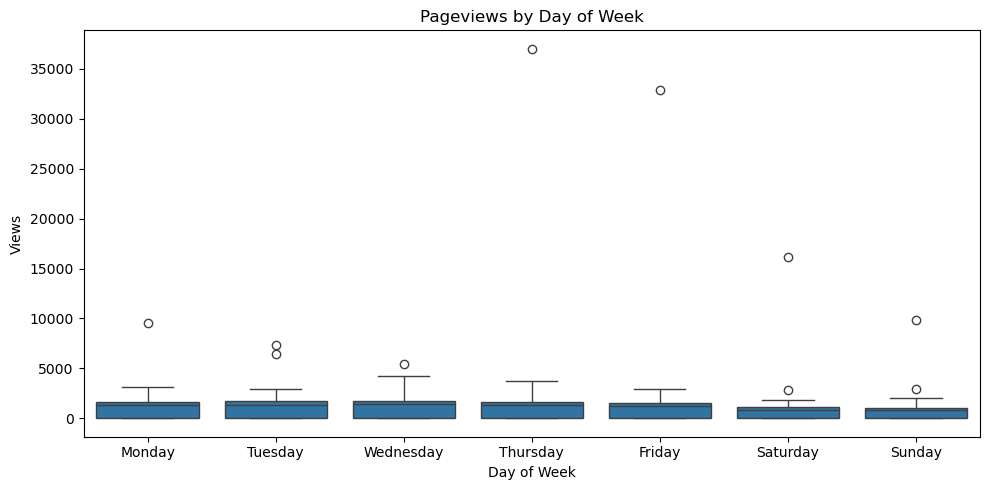

In [53]:
# Weekly seasonality boxplot
df_daily['day_of_week'] = df_daily.index.day_name()

plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='views', data=df_daily, order=[
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Pageviews by Day of Week')
plt.ylabel('Views')
plt.xlabel('Day of Week')
plt.tight_layout()
plt.show()

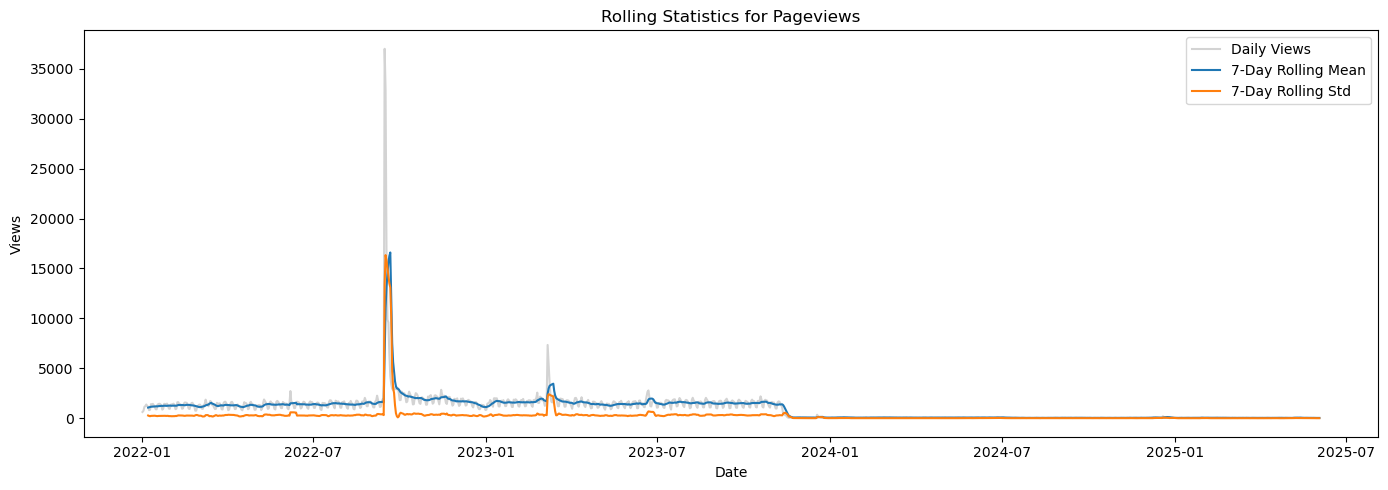

,views,rolling_avg,day_of_week,is_weekend,month,rolling_mean_7,rolling_std_7
count,1250.000000,1244.000000,1250.0000,1250.00000,1250.000000,1244.000000,1244.000000
mean,948.308000,950.546509,3.0000,0.28640,6.096800,950.546509,286.251831
std,1697.810192,1304.995642,2.0028,0.45226,3.462863,1304.995642,1143.576972
min,13.000000,32.142857,0.0000,0.00000,1.000000,32.142857,2.267787
25%,51.250000,54.250000,1.0000,0.00000,3.000000,54.250000,12.391433
50%,985.000000,1237.857143,3.0000,0.00000,6.000000,1237.857143,232.934999
75%,1563.750000,1500.035714,5.0000,1.00000,9.000000,1500.035714,309.470637
max,36996.000000,16599.000000,6.0000,1.00000,12.000000,16599.000000,16337.116596


In [55]:
# Rolling mean and std
df_daily['rolling_mean_7'] = df_daily['views'].rolling(window=7).mean()
df_daily['rolling_std_7'] = df_daily['views'].rolling(window=7).std()

plt.figure(figsize=(14, 5))
plt.plot(df_daily.index, df_daily['views'], color='lightgray', label='Daily Views')
plt.plot(df_daily.index, df_daily['rolling_mean_7'], label='7-Day Rolling Mean')
plt.plot(df_daily.index, df_daily['rolling_std_7'], label='7-Day Rolling Std')
plt.title('Rolling Statistics for Pageviews')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.tight_layout()
plt.show()

desc_stats

## Train-Test-Split

In [57]:
train_size = int(len(df_prophet) * 0.9)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

## Fit-Prophet

In [64]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(train_df)

08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:43 - cmdstanpy - INFO - Chain [1] done processing


## forecasting-with-prophet

In [66]:
future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

## Evaluation

In [81]:
forecast_test = forecast[['ds', 'yhat']].set_index('ds').join(test_df.set_index('ds'))
forecast_test = forecast_test.dropna()

y_true = forecast_test['y']
y_pred = forecast_test['yhat']
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

 ## Extend-Forecast-into-Mid-2026

In [86]:
# Extend Forecast into Mid-2026
model_full = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_full.fit(df_prophet)
future_extended = model_full.make_future_dataframe(periods=395, freq='D')  # mid-2026
forecast_extended = model_full.predict(future_extended)

df_daily.head(), mae, rmse, r2, forecast_extended[['ds', 'yhat']].tail()

08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:18 - cmdstanpy - INFO - Chain [1] done processing


(            views  rolling_avg day_of_week  is_weekend  month  rolling_mean_7  \
 date                                                                            
 2022-01-01    632          NaN    Saturday           1      1             NaN   
 2022-01-02    742          NaN      Sunday           1      1             NaN   
 2022-01-03   1134          NaN      Monday           0      1             NaN   
 2022-01-04   1217          NaN     Tuesday           0      1             NaN   
 2022-01-05   1378          NaN   Wednesday           0      1             NaN   
 
             rolling_std_7  
 date                       
 2022-01-01            NaN  
 2022-01-02            NaN  
 2022-01-03            NaN  
 2022-01-04            NaN  
 2022-01-05            NaN  ,
 257.9667067190158,
 319.33754113283385,
 -772.8058268639696,
              ds         yhat
 1640 2026-06-29  1328.063476
 1641 2026-06-30  1393.045506
 1642 2026-07-01  1357.532854
 1643 2026-07-02  1510.002742
 1644 20

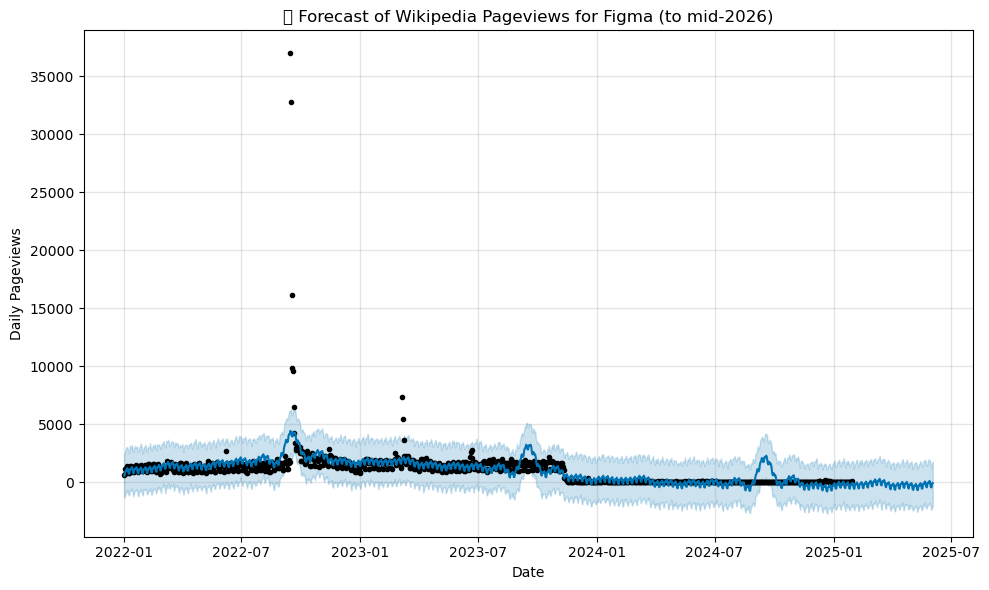

In [88]:
fig1 = model.plot(forecast)
plt.title("📈 Forecast of Wikipedia Pageviews for Figma (to mid-2026)")
plt.xlabel("Date")
plt.ylabel("Daily Pageviews")
plt.grid(True)
plt.tight_layout()
plt.show()

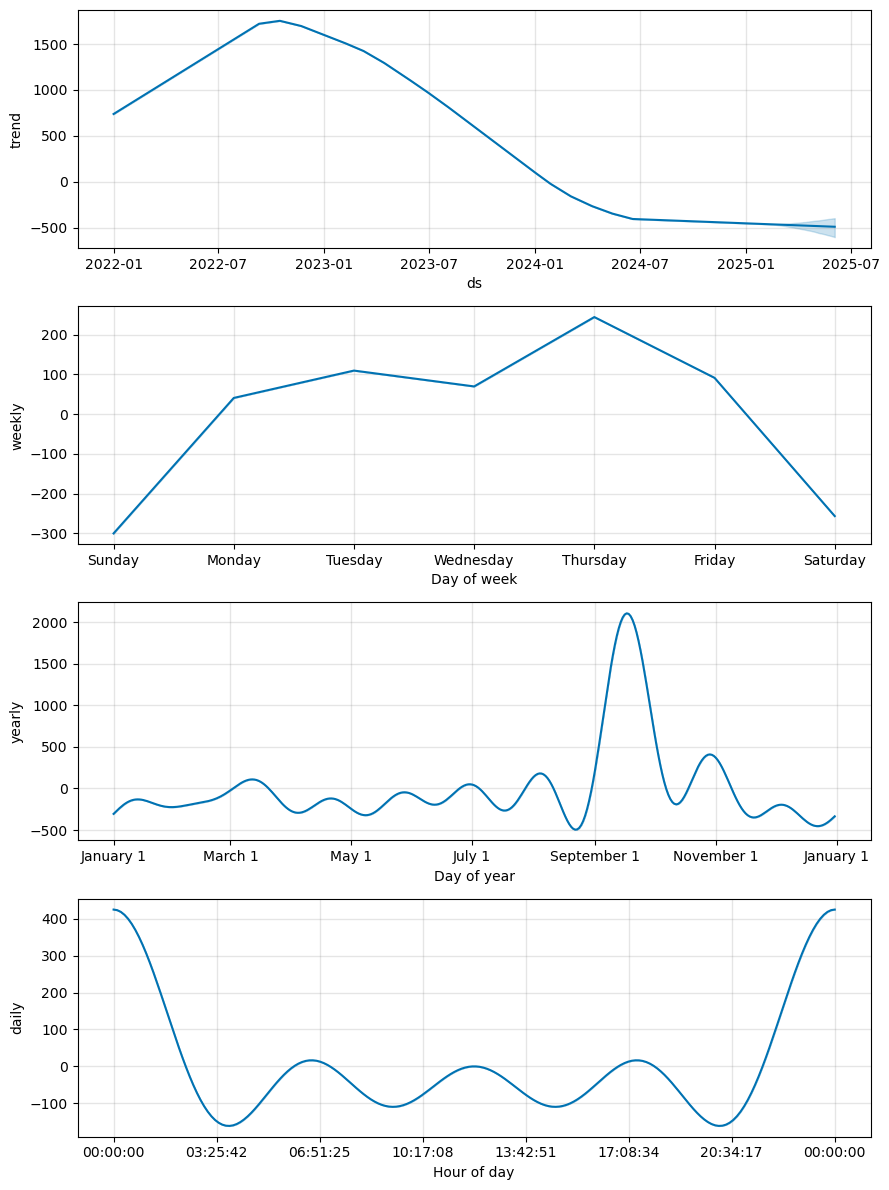

In [90]:
# Plot Forecast Components
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()